
# Nesterov et al, arXiv:2011.10011
In this notebook we want to capture the basic effect behind the two-qubit gate for fluxonia described in the paper by Nesterov et al(2020) "Proposal for entangling gates on fluxonium qubits via a two-photon transition"

In [52]:
import numpy as np
import xarray as xrr
import sys
import qutip as qtp 
import matplotlib.pyplot as plt
from scipy import constants
import pysqkit
from pysqkit.util.linalg import get_mat_elem, tensor_prod
from pysqkit.solvers import solvkit
from typing import List
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'

The gate is based on the following driven Hamiltonian of two-capacitively coupled fluxonium qubits

$$\hat{H} = \hat{H}^{(0)}_A + \hat{H}^{(0)}_B + \hat{V} + \hat{H}_{drive}$$

$$\hat{H}^{(0)}_A = 4 E_{C,A} \cdot \hat{n}^2_A + \frac{1}{2}E_{L,A}\cdot\hat{\varphi}^2_A - E_{J,A}\cos\left(\hat{\varphi}_A - \phi_{ext,A}\right)$$

$$\hat{H}^{(0)}_B = 4 E_{C,B} \cdot \hat{n}^2_B + \frac{1}{2}E_{L,B}\cdot\hat{\varphi}^2_B - E_{J,B}\cos\left(\hat{\varphi}_B - \phi_{ext,B}\right)$$

$$\hat{V} = J_C \cdot \hat{n}_A \cdot \hat{n}_B$$

$$\hat{H}_{drive} = 2  f\left( t \right)  \cos \left( \omega_d t + \gamma_d\right) \cdot \left( \eta_A \cdot \hat{n}_A + \eta_B \cdot \hat{n}_B \right)   \text{  with  } f\left( t \right) = f_0 \cdot \dfrac{f\left( t \right)}{f_0} $$

## 1. Single fluxonia
We take parameters as in Table 1 of the paper

In [2]:
# Values in GHz (divided by h)
#Fluxonium A
ec_a = 1.0
el_a = 1.5
ej_a = 3.8 
flux_a = 1/2
# Fluxonium B 
ec_b = 1.0
el_b = 0.9
ej_b = 3.0
flux_b = 1/2

n_fock = 100

Let us first reproduce the other parameters in Table 1

In [3]:
levels = 5
flx_a = pysqkit.qubits.Fluxonium('A', ec_a, el_a, ej_a, flux_a, dim_hilbert=n_fock)
flx_b = pysqkit.qubits.Fluxonium('B', ec_b, el_b, ej_b, flux_b, dim_hilbert=n_fock)
flx_a.diagonalize_basis(levels)
flx_b.diagonalize_basis(levels)
# If you run this twice it gives an error, so this has to be fixed in the source code

In [4]:
energies_a, eig_states_a = flx_a.eig_states(levels)
energies_b, eig_states_b = flx_b.eig_states(levels)
for k in range(0, 3):
    print('------')
    print('f_' + str(k) + str(k + 1) + '^A = ' + str(energies_a[k + 1] - energies_a[k]) + ' GHz' )
    print('f_' + str(k) + str(k + 1) + '^B = ' + str(energies_b[k + 1] - energies_b[k]) + ' GHz' )
print('------')

------
f_01^A = 1.1516938223021462 GHz
f_01^B = 0.8488266605313264 GHz
------
f_12^A = 3.28047980383017 GHz
f_12^B = 2.928638737996971 GHz
------
f_23^A = 3.253136053344173 GHz
f_23^B = 2.683497061311594 GHz
------


Thus, we correctly recover the frequencies Table 1 in the paper. Notice that the eigenenergies are also divided by $h$ and so are intended as frequencies and not as angular velocities. <br>
Let us also check the charge matrix elements in order to complete Table 1

In [5]:
for k in range(0, 2):
    print('------')
    print('|n_' + str(k) + str(k + 1) + '^A| = ' + \
          str(np.abs(get_mat_elem(flx_a.charge_op(), eig_states_a[k], eig_states_a[k + 1]))))
    print('|n_' + str(k) + str(k + 1) + '^B| = ' + \
          str(np.abs(get_mat_elem(flx_b.charge_op(), eig_states_b[k], eig_states_b[k + 1]))))
print('------')
print('|n_' + str(0) + str(3) + '^A| = '  + \
      str(np.abs(get_mat_elem(flx_a.charge_op(), eig_states_a[0], eig_states_a[3]))))
print('|n_' + str(0) + str(3) + '^B| = '  + \
      str(np.abs(get_mat_elem(flx_b.charge_op(), eig_states_b[0], eig_states_b[3]))))

------
|n_01^A| = 0.24866384335580374
|n_01^B| = 0.20722487336294074
------
|n_12^A| = 0.6084791377921789
|n_12^B| = 0.5665046936475009
------
|n_03^A| = 0.26017958759704296
|n_03^B| = 0.27731659042473


We thus recover all the results in Table 1. This could be used as a unit test. <br>
To change the basis to the diagonal basis you can use

In [6]:
energies_ab_bare = np.zeros(levels**2, dtype=float)
count = 0
for k in range(0, levels):
    for m in range(0, levels):
        energies_ab_bare[count] = energies_b[m] + energies_a[k]
        count += 1
label_converter = np.argsort(energies_ab_bare)

In [7]:
# This function allows to return the energy of the "adiabatically continued" coupled levels
def label_to_energies(
    k: int, 
    m: int,
    levels: int,
    energies: np.ndarray,
    label_converter: np.ndarray
) -> float:
    label = k*levels + m
    index = np.where(label_converter==label)[0][0]
    return energies[index]

def label_to_states(
    k: int, 
    m: int,
    levels: int,
    eig_states: np.ndarray,
    label_converter: np.ndarray
) -> float:
    label = k*levels + m
    index = np.where(label_converter==label)[0][0]
    return eig_states[index] 

## 2. Coupled fluxonia

As a preliminary study, I want to plot the energy levels of the coupled system as a function of the coupling strength $J_C$. I take coupling strengths similar to those taken in the paper (see Fig. 2).

In [8]:
n_points = 20
levels_plot = 6
jc_list = np.linspace(0, 0.4, n_points)
en_mat = np.zeros([levels_plot, n_points], dtype=float)
for k in range(0, n_points):
    coupled_flx = flx_a.couple_to(flx_b, coupling=pysqkit.couplers.capacitive_coupling, strength=jc_list[k])
    en_mat[:, k] = coupled_flx.eig_energies(levels_plot)

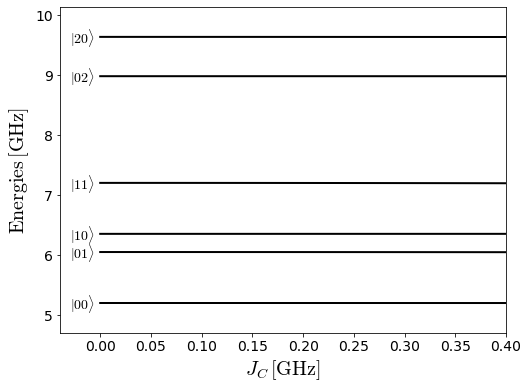

In [9]:
plot_setup = {'lw': 2.0, 'fs': 20, 'fs_text': 14, 'ls': 14}

def plot_energies_jc(
    en_mat: np.ndarray, 
    jc_list:np.ndarray, 
    opt:dict
) -> None:
    n_lev = en_mat.shape[0]
    text_lab = ["$| 00 \\rangle $", "$| 01 \\rangle $", "$| 10 \\rangle $", "$| 11 \\rangle $", \
                "$| 02 \\rangle $", "$| 20 \\rangle $"]
    fig, ax = plt.subplots(figsize=(8, 6))
    for k in range(0, n_lev):
        ax.plot(jc_list, en_mat[k, :], linewidth=opt['lw'], color='black')
        plt.text(-0.03, en_mat[k, 0] - 0.1, text_lab[k], fontsize=opt['fs_text'], color='black')
    ax.axes.set_xlabel("$J_C \, \mathrm{[GHz]}$", fontsize=opt['fs'])
    ax.axes.set_ylabel("$\mathrm{Energies \, [GHz]}$", fontsize=opt['fs'])
    ax.set_xlim([np.min(jc_list) - 0.04, np.max(jc_list)])
    ax.set_ylim([en_mat[0, 0] - 0.5, en_mat[n_lev - 1, 0] + 0.5])
    ax.tick_params(axis='both', labelsize=opt['ls'])
    plt.show()
    
plot_energies_jc(en_mat, jc_list, plot_setup)    

We see clearly that the introduction of the coupling bearly changes the eigenenergies since the fluxonia are sufficiently detuned. Thus, with these parameters we do not observe any avoided crossing and we can easily identify the levels by adiabatic continuation. To be more quantitative I plot the difference of the energies of $\lvert 10 \rangle$ and $\lvert 10 \rangle$ as a function of $J_C$

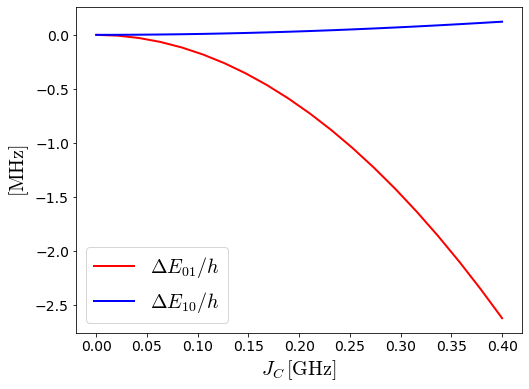

In [10]:
def plot_deltaen_jc(
    en_mat:np.ndarray, 
    jc_list:np.ndarray, 
    opt:dict
) -> None:
    col_list = ['red', 'blue']
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(jc_list, (en_mat[1, :] - en_mat[1, 0])*1e3, linewidth=opt['lw'], \
            color=col_list[0], label='$\Delta E_{01}/h$')
    ax.plot(jc_list, (en_mat[2, :] - en_mat[2, 0])*1e3, linewidth=opt['lw'], \
            color=col_list[1], label='$\Delta E_{10}/h$')
    ax.tick_params(axis='both', labelsize=opt['ls'])
    ax.axes.set_xlabel("$J_C \, \mathrm{[GHz]}$", fontsize=opt['fs'])
    ax.axes.set_ylabel("$\mathrm{[MHz]}$", fontsize=opt['fs'])
    plt.legend(fontsize=20)
    plt.show()

plot_deltaen_jc(en_mat, jc_list, plot_setup)  
    

The previous plot is not a standard plot of a two-level system were the two levels repel each other by an equal amount. This means that effects of other levels are important in fluxonia. <br>
I now work with a fixed coupling

In [11]:
jc = 0.3 #GHz (divided by h)
#drive frequency freq_drive = omega_d/2 \pi in the paper
freq_drive_bare = (energies_a[1] - energies_a[0] + energies_b[1] - energies_b[0])/2
coupled_flx = flx_a.couple_to(flx_b, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
energies_sys, eigstates_sys = coupled_flx.eig_states() 
freq_drive = (energies_sys[1] + energies_sys[2] - 2*energies_sys[0])/2
delta_ab = energies_sys[2] - energies_sys[1]

In [12]:
print('Bare drive frequency fd_bare: ' + str(freq_drive_bare) + ' [GHz]')
print('Drive frequency fd: ' + str(freq_drive) + ' [GHz]')

Bare drive frequency fd_bare: 1.0002602414167365 [GHz]
Drive frequency fd: 0.999797433128153 [GHz]


As we see there is barely any difference in the two ways of calculating the drive frequency for the present scheme. This is due to the relatively small coupling that we are considering. <br>
Following the paper we define the following quantities
$$ \Omega_{kl-k'l'} = 2 f \lvert N_{kl, k'l'} \rvert $$,
where $f$ is the strength of the drive and 
$$ N_{kl, k'l'} = \langle kl \rvert(\eta_A \hat{n}_A + \eta_B \hat{n} _B )\rvert k'l' \rangle$$. 
The Rabi frequency of the two-photon transition from second order perturbation theory is
$$
\tilde{\Omega} = \frac{\lvert \Omega_{00-01} \Omega_{01-11}- \Omega_{00-10} \Omega_{10-11} \rvert}{\Delta_{AB}}
$$,
with 
$$
\Delta_{AB} = \lvert \omega_{01}^A - \omega_{01}^B \rvert.
$$
These will all be given divided by $2 \pi$ in our calculations. I remark that in these calculations you have to take the hybridized states otherwise $\tilde{\Omega}$ is obviously zero.

In [13]:
def drive_mat_el(eta, n_charge, in_state, out_state):
    operator = eta[0]*n_charge[0] + eta[1]*n_charge[1]
    return np.abs(get_mat_elem(operator, in_state, out_state))

def twophoton_rabi_frequency(
    eta,
    n_charge,
    levels: int,
    eigstates_sys: np.ndarray,
    label_converter: np.ndarray,
    f0: float,
    delta_ab: float
) -> float:
    state00 = label_to_states(0, 0, levels, eigstates_sys, label_converter)
    state01 = label_to_states(0, 1, levels, eigstates_sys, label_converter)
    state10 = label_to_states(1, 0, levels, eigstates_sys, label_converter)
    state11 = label_to_states(1, 1, levels, eigstates_sys, label_converter)
    om_00_01 = 2*f0*drive_mat_el(eta, n_charge, state00, state01)
    om_01_11 = 2*f0*drive_mat_el(eta, n_charge, state01, state11)
    om_00_10 = 2*f0*drive_mat_el(eta, n_charge, state00, state10)
    om_10_11 = 2*f0*drive_mat_el(eta, n_charge, state10, state11)
    return (np.abs(om_00_01*om_01_11 - om_00_10*om_10_11))/delta_ab

def twophoton_rabi_frequencyv2(
    eta,
    n_01,
    f0: float,
    delta_ab: float,
    jc: float
) -> float:
    omega_a0 = 2*f0*eta[0]*n_01[0]
    omega_b0 = 2*f0*eta[1]*n_01[1]
    return 2*jc*n_01[0]*n_01[1]*(omega_a0**2 + omega_b0**2)/(delta_ab**2)


In [14]:
eta = [0.5, 0.5]
n_a = tensor_prod([flx_a.charge_op(), np.identity(levels)])
n_b = tensor_prod([np.identity(levels), flx_b.charge_op()])
n_charge = [n_a, n_b]
n_a_01 = np.abs(get_mat_elem(flx_a.charge_op(), eig_states_a[0], eig_states_a[1]))
n_b_01 = np.abs(get_mat_elem(flx_b.charge_op(), eig_states_b[0], eig_states_b[1]))
n_01 = [n_a_01, n_b_01]
lambda_drive = 1.0 #dimensionless drive frequency
f0 = lambda_drive*delta_ab/(2*eta[0]*n_a_01)
n_a = tensor_prod([flx_a.charge_op(), np.identity(levels)])
n_b = tensor_prod([np.identity(levels), flx_b.charge_op()])
state00 = label_to_states(0, 0, levels, eigstates_sys, label_converter)
state01 = label_to_states(0, 1, levels, eigstates_sys, label_converter)
state10 = label_to_states(1, 0, levels, eigstates_sys, label_converter)
state11 = label_to_states(1, 1, levels, eigstates_sys, label_converter)


In [15]:
rabi_freq = twophoton_rabi_frequency(eta, n_charge, levels, 
                                     eigstates_sys, label_converter, f0, delta_ab) # [GHz]
rabi_freqv2 = twophoton_rabi_frequencyv2(eta, n_01, f0, delta_ab, jc)
rabi_period = 1/rabi_freq # [ns]
rabi_periodv2 = 1/rabi_freqv2
print('Rabi period: ' + str(rabi_period) + ' [ns]')
print('Rabi period: ' + str(rabi_periodv2) + ' [ns]')

Rabi period: 19.98545067255053 [ns]
Rabi period: 19.08790630315005 [ns]


### 2.1 Simulations

We now want to perform simulations. The first task is to reproduce the two-photon Rabi oscillations and show that they reproduce correctly the Rabi period.

In [16]:
#simulation setup (noiseless)
times = np.linspace(0, 2*rabi_period*2*np.pi, 10000)
rho_in = coupled_flx.state('00', as_qobj=True, as_dm=True)
term_coeffs = [0.5, 0.5]
drive_hamil = sum(coeff*qubit.charge_op(as_qobj=True) for coeff, qubit in zip(term_coeffs, coupled_flx.qubits))
pulse_drive = 2*f0*np.cos(freq_drive*times)

In [17]:
# Simulation run
result = solvkit.integrate(times, rho_in, coupled_flx.hamiltonian(as_qobj=True), [drive_hamil], [pulse_drive], [], "mesolve")

In [56]:
comp_state_labels = ['00', '01', '10', '11']
comp_states = [coupled_flx.state(label, as_qobj=True, as_dm=True) for label in comp_state_labels]
_probs = np.array([[qtp.expect(comp_state, end_state) for end_state in result.states] for comp_state in comp_states])
probs = xr.DataArray(_probs, dims=['state', 'time'], coords=dict(time=times, state=comp_state_labels))

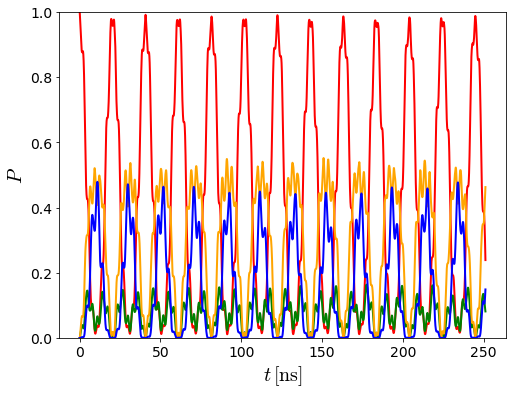

In [57]:
cols = ['red', 'green', 'orange', 'blue']
fig, ax = plt.subplots(figsize=(8, 6))
for state, col in zip(probs.state, cols):
    ax.plot(probs.time, probs.sel(state=state), linewidth=plot_setup['lw'], color=col)
ax.axes.set_xlabel('$t \, [\mathrm{ns}]$', fontsize=plot_setup['fs'])
ax.axes.set_ylabel('$P$', fontsize=plot_setup['fs'])
ax.tick_params(axis='both', labelsize=plot_setup['ls'])
ax.set_ylim(0, 1.0)
plt.show()

In [58]:
rabi_period

19.98545067255053